# Market Basket Analysis

This notebook performs market basket analysis to identify products frequently purchased together, revealing shopping patterns and cross-selling opportunities for strategic merchandising and promotional planning.

## Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import Counter
from completejourney_py import get_data

# Set plotting style
plt.style.use('default')
sns.set_palette("viridis")

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [2]:
# Load required datasets
data = get_data(["transactions", "products"])
transactions = data["transactions"]
products = data["products"]

print(f"Loaded {len(transactions):,} transaction records")
print(f"Loaded {len(products):,} product records")

# Show basket-level summary
basket_summary = (
    transactions
    .groupby('basket_id')
    .agg({
        'product_id': 'nunique',
        'sales_value': 'sum',
        'quantity': 'sum'
    })
    .rename(columns={'product_id': 'unique_products'})
)

print(f"\nBasket Analysis Overview:")
print(f"- Total baskets: {len(basket_summary):,}")
print(f"- Average products per basket: {basket_summary['unique_products'].mean():.1f}")
print(f"- Median products per basket: {basket_summary['unique_products'].median():.1f}")
print(f"- Max products in single basket: {basket_summary['unique_products'].max()}")
print(f"- Average basket value: ${basket_summary['sales_value'].mean():.2f}")

Loaded 1,469,307 transaction records
Loaded 92,331 product records

Basket Analysis Overview:
- Total baskets: 155,848
- Average products per basket: 9.4
- Median products per basket: 5.0
- Max products in single basket: 161
- Average basket value: $29.49


## Data Preparation: Create Product Categories for Analysis

In [3]:
# Merge transactions with product information
basket_data = (
    transactions
    .merge(products[['product_id', 'product_category', 'department', 'brand']], 
           on='product_id', how='left')
)

print(f"Combined dataset: {len(basket_data):,} transaction records")
print(f"- Unique product categories: {basket_data['product_category'].nunique():,}")
print(f"- Unique departments: {basket_data['department'].nunique()}")

# Filter out coupon/misc items for meaningful basket analysis
excluded_categories = [
    'COUPON/MISC ITEMS', 
    'MISCELLANEOUS',
    'COUPON',
    'MISC ITEMS',
    'PHARMACEUTICAL',
    'RX CLAIMS'
]

basket_data_clean = basket_data[
    ~basket_data['product_category'].isin(excluded_categories)
].copy()

print(f"\nAfter filtering out coupons/misc: {len(basket_data_clean):,} transactions")
print(f"- Unique product categories: {basket_data_clean['product_category'].nunique():,}")

# Show distribution of basket sizes
clean_basket_summary = (
    basket_data_clean
    .groupby('basket_id')
    .agg({
        'product_category': 'nunique',
        'sales_value': 'sum'
    })
    .rename(columns={'product_category': 'unique_categories'})
)

print(f"\nClean Basket Statistics:")
print(f"- Average categories per basket: {clean_basket_summary['unique_categories'].mean():.1f}")
print(f"- Baskets with 2+ categories: {(clean_basket_summary['unique_categories'] >= 2).sum():,} ({(clean_basket_summary['unique_categories'] >= 2).mean()*100:.1f}%)")
print(f"- Baskets with 5+ categories: {(clean_basket_summary['unique_categories'] >= 5).sum():,} ({(clean_basket_summary['unique_categories'] >= 5).mean()*100:.1f}%)")

Combined dataset: 1,469,307 transaction records
- Unique product categories: 302
- Unique departments: 30

After filtering out coupons/misc: 1,451,904 transactions
- Unique product categories: 299

Clean Basket Statistics:
- Average categories per basket: 7.4
- Baskets with 2+ categories: 116,668 (81.8%)
- Baskets with 5+ categories: 69,258 (48.5%)


## Approach 1: Category-Level Basket Analysis

In [4]:
# Create basket-category matrix for category-level analysis
basket_categories = (
    basket_data_clean
    .groupby(['basket_id', 'product_category'])
    .size()
    .reset_index(name='quantity')
    .assign(purchased=1)
    .pivot_table(index='basket_id', columns='product_category', values='purchased', fill_value=0)
)

print(f"Basket-Category Matrix: {basket_categories.shape[0]:,} baskets × {basket_categories.shape[1]} categories")

# Filter to baskets with multiple categories for meaningful associations
multi_category_baskets = basket_categories[basket_categories.sum(axis=1) >= 2]
print(f"Baskets with 2+ categories for analysis: {len(multi_category_baskets):,}")

# Calculate category support (frequency)
category_support = (multi_category_baskets.sum() / len(multi_category_baskets) * 100).sort_values(ascending=False)

print(f"\nTop 15 Most Popular Categories (% of multi-category baskets):")
for i, (category, support) in enumerate(category_support.head(15).items()):
    print(f"{i+1:2d}. {category}: {support:.1f}% ({int(support * len(multi_category_baskets) / 100):,} baskets)")

Basket-Category Matrix: 142,286 baskets × 299 categories
Baskets with 2+ categories for analysis: 116,668

Top 15 Most Popular Categories (% of multi-category baskets):
 1. FLUID MILK PRODUCTS: 32.7% (38,189 baskets)
 2. SOFT DRINKS: 31.7% (37,035 baskets)
 3. BAKED BREAD/BUNS/ROLLS: 28.8% (33,641 baskets)
 4. CHEESE: 22.7% (26,441 baskets)
 5. BAG SNACKS: 20.1% (23,485 baskets)
 6. BEEF: 17.5% (20,404 baskets)
 7. TROPICAL FRUIT: 15.8% (18,448 baskets)
 8. EGGS: 13.4% (15,576 baskets)
 9. COLD CEREAL: 12.1% (14,112 baskets)
10. REFRGRATD JUICES/DRNKS: 12.1% (14,094 baskets)
11. LUNCHMEAT: 11.2% (13,105 baskets)
12. SOUP: 11.2% (13,072 baskets)
13. CRACKERS/MISC BKD FD: 10.9% (12,714 baskets)
14. FRZN MEAT/MEAT DINNERS: 10.8% (12,608 baskets)
15. VEGETABLES - SHELF STABLE: 10.8% (12,551 baskets)


In [5]:
# Find category pairs with highest co-occurrence
def calculate_category_pairs(basket_matrix, min_support=0.01):
    """Calculate support, confidence, and lift for category pairs"""
    
    # Filter categories with minimum support
    frequent_categories = (basket_matrix.sum() / len(basket_matrix)) >= min_support
    basket_frequent = basket_matrix.loc[:, frequent_categories]
    
    # Calculate pairwise associations
    associations = []
    
    for cat1 in basket_frequent.columns:
        for cat2 in basket_frequent.columns:
            if cat1 != cat2:
                # Support calculations
                support_cat1 = basket_frequent[cat1].sum() / len(basket_frequent)
                support_cat2 = basket_frequent[cat2].sum() / len(basket_frequent)
                support_both = ((basket_frequent[cat1] == 1) & (basket_frequent[cat2] == 1)).sum() / len(basket_frequent)
                
                if support_both > 0:
                    # Confidence: P(cat2|cat1)
                    confidence = support_both / support_cat1
                    
                    # Lift: support(cat1,cat2) / (support(cat1) * support(cat2))
                    lift = support_both / (support_cat1 * support_cat2)
                    
                    associations.append({
                        'category_1': cat1,
                        'category_2': cat2,
                        'support': support_both,
                        'confidence': confidence,
                        'lift': lift,
                        'basket_count': int(support_both * len(basket_frequent))
                    })
    
    return pd.DataFrame(associations)

# Calculate category associations
category_associations = calculate_category_pairs(multi_category_baskets, min_support=0.05)

print(f"Total category pair associations found: {len(category_associations):,}")
print(f"\nTop 10 Category Pairs by Support (frequency of co-occurrence):")
print("=" * 80)

top_support = category_associations.nlargest(10, 'support')
n = 0
for i, row in top_support.iterrows():
    n += 1
    print(f"{n:2d}. {row['category_1']} → {row['category_2']}")
    print(f"    Support: {row['support']:.1%} | Confidence: {row['confidence']:.1%} | Lift: {row['lift']:.2f} | Baskets: {row['basket_count']:,}")

print(f"\nTop 10 Category Pairs by Lift (strength of association):")
print("=" * 80)

top_lift = category_associations.nlargest(10, 'lift')
n = 0
for i, row in top_lift.iterrows():
    n += 1
    print(f"{n:2d}. {row['category_1']} → {row['category_2']}")
    print(f"    Support: {row['support']:.1%} | Confidence: {row['confidence']:.1%} | Lift: {row['lift']:.2f} | Baskets: {row['basket_count']:,}")

Total category pair associations found: 3,422

Top 10 Category Pairs by Support (frequency of co-occurrence):
 1. BAKED BREAD/BUNS/ROLLS → FLUID MILK PRODUCTS
    Support: 15.0% | Confidence: 52.2% | Lift: 1.59 | Baskets: 17,554
 2. FLUID MILK PRODUCTS → BAKED BREAD/BUNS/ROLLS
    Support: 15.0% | Confidence: 46.0% | Lift: 1.59 | Baskets: 17,554
 3. FLUID MILK PRODUCTS → SOFT DRINKS
    Support: 12.2% | Confidence: 37.3% | Lift: 1.17 | Baskets: 14,234
 4. SOFT DRINKS → FLUID MILK PRODUCTS
    Support: 12.2% | Confidence: 38.4% | Lift: 1.17 | Baskets: 14,234
 5. CHEESE → FLUID MILK PRODUCTS
    Support: 12.0% | Confidence: 53.0% | Lift: 1.62 | Baskets: 14,017
 6. FLUID MILK PRODUCTS → CHEESE
    Support: 12.0% | Confidence: 36.7% | Lift: 1.62 | Baskets: 14,017
 7. BAKED BREAD/BUNS/ROLLS → SOFT DRINKS
    Support: 11.7% | Confidence: 40.7% | Lift: 1.28 | Baskets: 13,703
 8. SOFT DRINKS → BAKED BREAD/BUNS/ROLLS
    Support: 11.7% | Confidence: 37.0% | Lift: 1.28 | Baskets: 13,703
 9. BAKE

## Approach 2: Department-Level Basket Analysis

In [6]:
# Analyze basket patterns at department level for broader insights
basket_departments = (
    basket_data_clean
    .groupby(['basket_id', 'department'])
    .size()
    .reset_index(name='items')
    .assign(purchased=1)
    .pivot_table(index='basket_id', columns='department', values='purchased', fill_value=0)
)

print(f"Department Analysis: {basket_departments.shape[0]:,} baskets × {basket_departments.shape[1]} departments")

# Filter to multi-department baskets
multi_dept_baskets = basket_departments[basket_departments.sum(axis=1) >= 2]
print(f"Baskets with 2+ departments: {len(multi_dept_baskets):,} ({len(multi_dept_baskets)/len(basket_departments)*100:.1f}%)")

# Department popularity
dept_support = (multi_dept_baskets.sum() / len(multi_dept_baskets) * 100).sort_values(ascending=False)

print(f"\nTop 10 Departments in Multi-Department Baskets:")
for i, (dept, support) in enumerate(dept_support.head(10).items()):
    print(f"{i+1:2d}. {dept}: {support:.1f}% ({int(support * len(multi_dept_baskets) / 100):,} baskets)")

# Find strongest department associations
dept_associations = calculate_category_pairs(multi_dept_baskets, min_support=0.10)

print(f"\nTop 10 Department Pairs by Lift:")
print("=" * 70)

top_dept_lift = dept_associations.nlargest(10, 'lift')
n = 0
for i, row in top_dept_lift.iterrows():
    n += 1    
    print(f"{n:2d}. {row['category_1']} + {row['category_2']}")
    print(f"    Support: {row['support']:.1%} | Confidence: {row['confidence']:.1%} | Lift: {row['lift']:.2f}")

Department Analysis: 142,320 baskets × 27 departments
Baskets with 2+ departments: 98,381 (69.1%)

Top 10 Departments in Multi-Department Baskets:
 1. GROCERY: 95.4% (93,831 baskets)
 2. DRUG GM: 57.8% (56,881 baskets)
 3. PRODUCE: 50.4% (49,563 baskets)
 4. MEAT-PCKGD: 32.7% (32,135 baskets)
 5. MEAT: 30.1% (29,580 baskets)
 6. DELI: 19.3% (19,011 baskets)
 7. PASTRY: 16.5% (16,270 baskets)
 8. NUTRITION: 9.6% (9,468 baskets)
 9. SEAFOOD-PCKGD: 5.1% (5,019 baskets)
10. SALAD BAR: 4.3% (4,244 baskets)

Top 10 Department Pairs by Lift:
 1. MEAT + MEAT-PCKGD
    Support: 14.6% | Confidence: 48.7% | Lift: 1.49
 2. MEAT-PCKGD + MEAT
    Support: 14.6% | Confidence: 44.8% | Lift: 1.49
 3. DELI + PASTRY
    Support: 4.7% | Confidence: 24.3% | Lift: 1.47
 4. PASTRY + DELI
    Support: 4.7% | Confidence: 28.5% | Lift: 1.47
 5. MEAT + PRODUCE
    Support: 20.5% | Confidence: 68.1% | Lift: 1.35
 6. PRODUCE + MEAT
    Support: 20.5% | Confidence: 40.7% | Lift: 1.35
 7. DELI + PRODUCE
    Support:

## Approach 3: Individual Product Basket Analysis

In [7]:
# Analyze specific product combinations for detailed insights
# Focus on products with reasonable frequency to avoid sparse data

# Find top products by basket frequency
product_basket_freq = (
    basket_data_clean
    .groupby('product_id')
    .agg({
        'basket_id': 'nunique',
        'product_category': 'first',
        'department': 'first',
        'brand': 'first'
    })
    .rename(columns={'basket_id': 'basket_count'})
    .sort_values('basket_count', ascending=False)
)

# Filter to products appearing in at least 100 baskets for meaningful analysis
frequent_products = product_basket_freq[product_basket_freq['basket_count'] >= 100]

print(f"Products appearing in 100+ baskets: {len(frequent_products):,}")
print(f"\nTop 15 Most Frequent Products in Baskets:")
for i, (product_id, row) in enumerate(frequent_products.head(15).iterrows()):
    print(f"{i+1:2d}. Product {product_id} ({row['product_category']}) - {row['department']}: {row['basket_count']:,} baskets")

# Create product co-occurrence matrix for top products
top_products = frequent_products.head(50).index.tolist()

basket_products = (
    basket_data_clean[basket_data_clean['product_id'].isin(top_products)]
    .groupby(['basket_id', 'product_id'])
    .size()
    .reset_index(name='quantity')
    .assign(purchased=1)
    .pivot_table(index='basket_id', columns='product_id', values='purchased', fill_value=0)
)

print(f"\nProduct co-occurrence matrix: {basket_products.shape[0]:,} baskets × {basket_products.shape[1]} products")

# Find top product pairs
product_pairs = []

for i, prod1 in enumerate(basket_products.columns):
    for j, prod2 in enumerate(basket_products.columns):
        if i < j:  # Avoid duplicates and self-pairs
            # Calculate co-occurrence
            both_purchased = ((basket_products[prod1] == 1) & (basket_products[prod2] == 1)).sum()
            prod1_purchased = (basket_products[prod1] == 1).sum()
            prod2_purchased = (basket_products[prod2] == 1).sum()
            
            if both_purchased >= 10:  # Minimum co-occurrence threshold
                support = both_purchased / len(basket_products)
                confidence_1_to_2 = both_purchased / prod1_purchased
                confidence_2_to_1 = both_purchased / prod2_purchased
                
                # Get product details
                prod1_details = frequent_products.loc[prod1]
                prod2_details = frequent_products.loc[prod2]
                
                product_pairs.append({
                    'product_1': prod1,
                    'product_2': prod2,
                    'product_1_category': prod1_details['product_category'],
                    'product_2_category': prod2_details['product_category'],
                    'co_occurrence': both_purchased,
                    'support': support,
                    'confidence_1_to_2': confidence_1_to_2,
                    'confidence_2_to_1': confidence_2_to_1
                })

product_pairs_df = pd.DataFrame(product_pairs).sort_values('co_occurrence', ascending=False)

print(f"\nTop 10 Product Pairs by Co-occurrence:")
print("=" * 90)

n = 0
for i, row in product_pairs_df.head(10).iterrows():
    n += 1
    print(f"{n:2d}. Product {row['product_1']} ({row['product_1_category']}) + Product {row['product_2']} ({row['product_2_category']})")
    print(f"    Co-occurrence: {row['co_occurrence']} baskets | Support: {row['support']:.2%} | Confidence: {row['confidence_1_to_2']:.1%} / {row['confidence_2_to_1']:.1%}")

Products appearing in 100+ baskets: 2,766

Top 15 Most Frequent Products in Baskets:
 1. Product 1082185 (TROPICAL FRUIT) - PRODUCE: 16,992 baskets
 2. Product 1029743 (FLUID MILK PRODUCTS) - GROCERY: 7,874 baskets
 3. Product 995242 (FLUID MILK PRODUCTS) - GROCERY: 7,441 baskets
 4. Product 1106523 (FLUID MILK PRODUCTS) - GROCERY: 5,424 baskets
 5. Product 981760 (EGGS) - GROCERY: 5,181 baskets
 6. Product 1133018 (FLUID MILK PRODUCTS) - GROCERY: 4,231 baskets
 7. Product 883404 (BAKED BREAD/BUNS/ROLLS) - GROCERY: 3,800 baskets
 8. Product 1127831 (BERRIES) - PRODUCE: 3,551 baskets
 9. Product 951590 (BAKED BREAD/BUNS/ROLLS) - GROCERY: 3,291 baskets
10. Product 826249 (BAKED BREAD/BUNS/ROLLS) - GROCERY: 3,192 baskets
11. Product 840361 (EGGS) - GROCERY: 3,039 baskets
12. Product 908531 (FLUID MILK PRODUCTS) - GROCERY: 3,001 baskets
13. Product 5978656 (None) - None: 2,932 baskets
14. Product 995785 (PEPPERS-ALL) - PRODUCE: 2,925 baskets
15. Product 1098066 (BAKED BREAD/BUNS/ROLLS) - G

## Visualization: Basket Analysis Insights

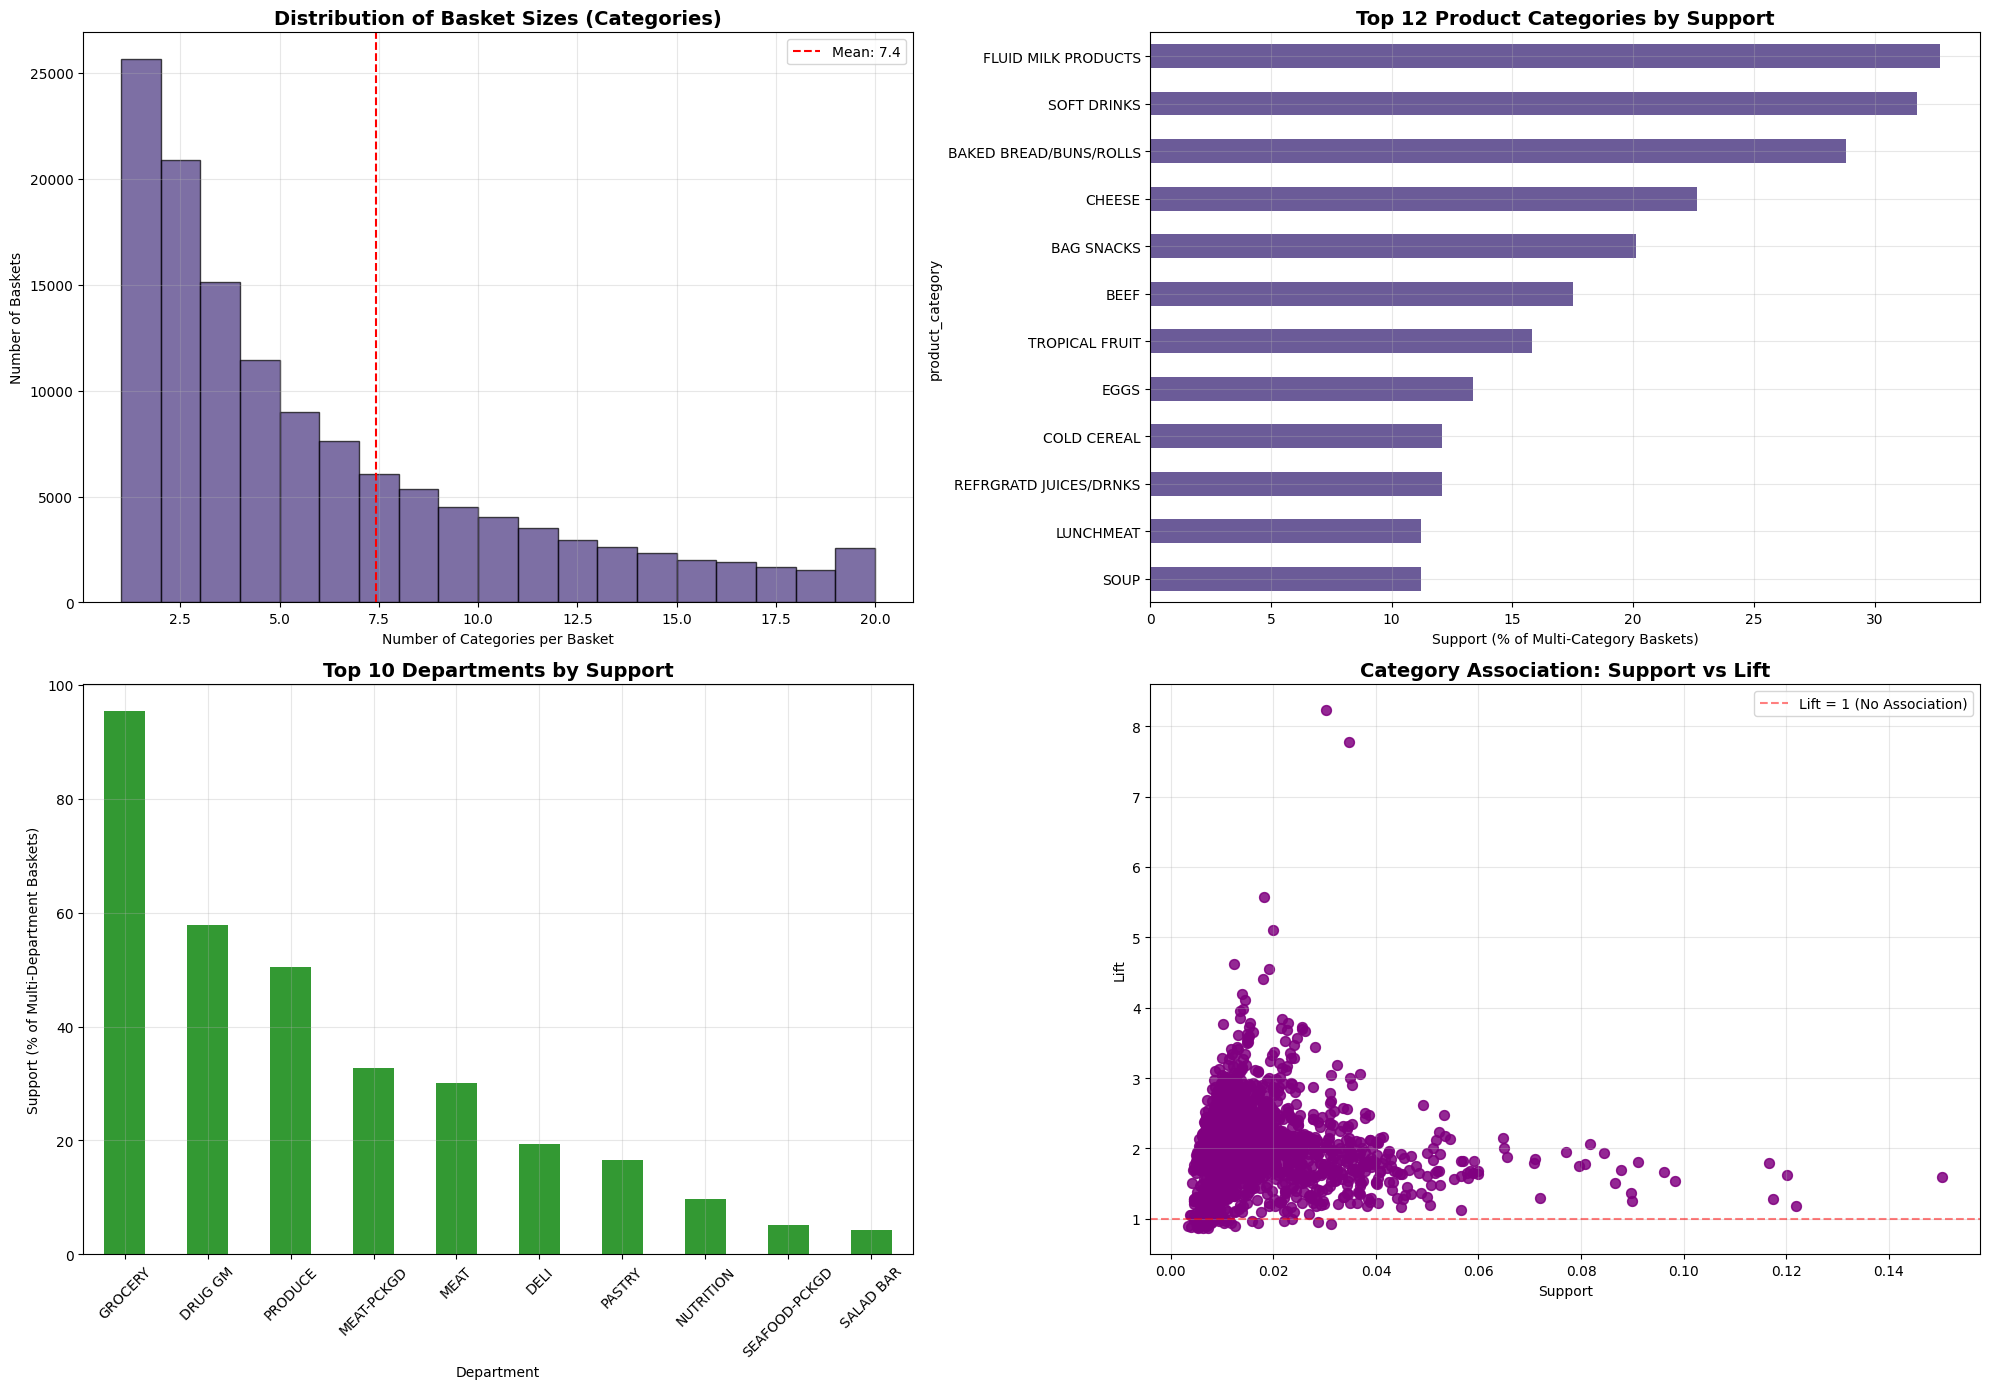


Basket Analysis Summary:
- Average categories per basket: 7.4
- 48.5% of baskets contain 5+ categories
- 69.1% of baskets span multiple departments
- Found 3,422 category pair associations
- Found 1,209 frequent product pair associations


In [8]:
# Create comprehensive visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 14))

# 1. Distribution of basket sizes (number of categories)
clean_basket_summary['unique_categories'].hist(bins=range(1, 21), alpha=0.7, edgecolor='black', ax=ax1)
ax1.set_xlabel('Number of Categories per Basket')
ax1.set_ylabel('Number of Baskets')
ax1.set_title('Distribution of Basket Sizes (Categories)', fontsize=14, fontweight='bold')
ax1.axvline(clean_basket_summary['unique_categories'].mean(), color='red', linestyle='--', 
           label=f'Mean: {clean_basket_summary["unique_categories"].mean():.1f}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Top category supports
category_support.head(12).sort_values().plot(kind='barh', ax=ax2, alpha=0.8)
ax2.set_xlabel('Support (% of Multi-Category Baskets)')
ax2.set_title('Top 12 Product Categories by Support', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Top department supports
dept_support.head(10).plot(kind='bar', ax=ax3, alpha=0.8, color='green')
ax3.set_xlabel('Department')
ax3.set_ylabel('Support (% of Multi-Department Baskets)')
ax3.set_title('Top 10 Departments by Support', fontsize=14, fontweight='bold')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)

# 4. Lift vs Support scatter for category pairs
if len(category_associations) > 0:
    ax4.scatter(category_associations['support'], category_associations['lift'], 
               alpha=0.6, s=50, c='purple')
    ax4.set_xlabel('Support')
    ax4.set_ylabel('Lift')
    ax4.set_title('Category Association: Support vs Lift', fontsize=14, fontweight='bold')
    ax4.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Lift = 1 (No Association)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nBasket Analysis Summary:")
print(f"- Average categories per basket: {clean_basket_summary['unique_categories'].mean():.1f}")
print(f"- {(clean_basket_summary['unique_categories'] >= 5).mean()*100:.1f}% of baskets contain 5+ categories")
print(f"- {len(multi_dept_baskets)/len(basket_departments)*100:.1f}% of baskets span multiple departments")
print(f"- Found {len(category_associations):,} category pair associations")
print(f"- Found {len(product_pairs_df):,} frequent product pair associations")

## Cross-Department Shopping Patterns

In [9]:
# Analyze shopping patterns across departments for store layout insights
dept_combinations = []

# Focus on most popular departments for meaningful analysis
top_departments = dept_support.head(8).index.tolist()

for basket_id, row in multi_dept_baskets.iterrows():
    # Get departments purchased in this basket
    purchased_depts = [dept for dept in top_departments if row[dept] == 1]
    
    # Generate all pairs of departments in this basket
    if len(purchased_depts) >= 2:
        for dept1, dept2 in combinations(purchased_depts, 2):
            dept_combinations.append((min(dept1, dept2), max(dept1, dept2)))

# Count department pair frequencies
dept_pair_counts = Counter(dept_combinations)

print(f"Cross-Department Shopping Patterns:")
print(f"=" * 60)
print(f"Total department pair occurrences: {sum(dept_pair_counts.values()):,}")
print(f"\nTop 15 Department Combinations:")

for i, ((dept1, dept2), count) in enumerate(dept_pair_counts.most_common(15)):
    pct = count / len(multi_dept_baskets) * 100
    print(f"{i+1:2d}. {dept1} + {dept2}: {count:,} baskets ({pct:.1f}%)")

# Calculate department affinity (how often departments appear together)
print(f"\nDepartment Affinity Analysis:")
print(f"Departments most likely to be shopped together with GROCERY:")

grocery_pairs = [(pair, count) for pair, count in dept_pair_counts.items() if 'GROCERY' in pair]
grocery_pairs_sorted = sorted(grocery_pairs, key=lambda x: x[1], reverse=True)

for i, ((dept1, dept2), count) in enumerate(grocery_pairs_sorted[:8]):
    other_dept = dept2 if dept1 == 'GROCERY' else dept1
    affinity = count / multi_dept_baskets['GROCERY'].sum() * 100
    print(f"{i+1}. GROCERY + {other_dept}: {affinity:.1f}% affinity ({count:,} co-occurrences)")

Cross-Department Shopping Patterns:
Total department pair occurrences: 410,513

Top 15 Department Combinations:
 1. DRUG GM + GROCERY: 53,836 baskets (54.7%)
 2. GROCERY + PRODUCE: 47,914 baskets (48.7%)
 3. GROCERY + MEAT-PCKGD: 31,615 baskets (32.1%)
 4. GROCERY + MEAT: 28,879 baskets (29.4%)
 5. DRUG GM + PRODUCE: 26,117 baskets (26.5%)
 6. MEAT + PRODUCE: 20,155 baskets (20.5%)
 7. MEAT-PCKGD + PRODUCE: 19,639 baskets (20.0%)
 8. DELI + GROCERY: 18,157 baskets (18.5%)
 9. DRUG GM + MEAT-PCKGD: 17,315 baskets (17.6%)
10. DRUG GM + MEAT: 15,535 baskets (15.8%)
11. GROCERY + PASTRY: 15,249 baskets (15.5%)
12. MEAT + MEAT-PCKGD: 14,399 baskets (14.6%)
13. DELI + PRODUCE: 11,834 baskets (12.0%)
14. DELI + DRUG GM: 10,160 baskets (10.3%)
15. PASTRY + PRODUCE: 9,363 baskets (9.5%)

Department Affinity Analysis:
Departments most likely to be shopped together with GROCERY:
1. GROCERY + DRUG GM: 57.4% affinity (53,836 co-occurrences)
2. GROCERY + PRODUCE: 51.1% affinity (47,914 co-occurrence

## Alternative Approaches to Basket Analysis

This analysis demonstrates several approaches to market basket analysis, each revealing different insights:

### **Approaches Demonstrated:**

**1. Category-Level Analysis**
- **Purpose**: Understand product category relationships
- **Metrics**: Support, confidence, lift for category pairs
- **Business Value**: Category management, cross-merchandising strategies

**2. Department-Level Analysis** 
- **Purpose**: Store layout and shopping flow optimization
- **Metrics**: Department co-occurrence, affinity analysis
- **Business Value**: Store design, staff allocation, inventory placement

**3. Individual Product Analysis**
- **Purpose**: Specific product recommendations and bundling
- **Metrics**: Product pair co-occurrence, confidence scores
- **Business Value**: Product recommendations, promotional bundles

**4. Cross-Department Pattern Analysis**
- **Purpose**: Understanding shopping journey across store sections
- **Metrics**: Department combination frequencies, affinity scores
- **Business Value**: Store layout optimization, traffic flow analysis

### **Additional Approaches to Explore:**

**Temporal Basket Analysis:**
```python
# Analyze how basket composition changes by:
# - Time of day
# - Day of week  
# - Season/month
# - Before/after holidays
```

**Brand-Level Analysis:**
```python
# Examine brand switching and loyalty patterns:
# - National vs private label combinations
# - Brand affinity within categories
# - Cross-brand purchasing patterns
```

**Customer Segment Basket Analysis:**
```python
# Segment-specific basket patterns:
# - High-value vs low-value customers
# - Frequent vs occasional shoppers
# - Demographic-based basket differences
```

**Sequential Pattern Mining:**
```python
# Analyze purchase sequences:
# - Order of items added to basket
# - Shopping path through store departments
# - Temporal patterns within shopping trips
```

**Advanced Association Rule Mining:**
```python
# Implement algorithms like:
# - Apriori algorithm for frequent itemsets
# - FP-Growth for efficient pattern mining
# - Eclat algorithm for itemset mining
```

**Basket Size and Value Analysis:**
```python
# Analyze basket characteristics:
# - Small vs large basket composition differences
# - Value-based basket segmentation
# - Impulse vs planned purchase patterns
```

**Statistical Significance Testing:**
```python
# Test association strength:
# - Chi-square tests for independence
# - Confidence intervals for lift metrics
# - Bootstrap sampling for robust estimates
```

### **Experimentation Recommendations:**

1. **Try Different Granularities**: Experiment with product categories, sub-categories, brands, and individual products

2. **Adjust Thresholds**: Modify minimum support and confidence thresholds to balance comprehensiveness vs statistical significance

3. **Explore Time Dimensions**: Add temporal analysis to understand how associations change over time

4. **Consider Customer Context**: Incorporate customer demographics and shopping behavior for personalized insights

5. **Validate Business Impact**: Test insights through A/B testing of product placements, recommendations, or promotions

Each approach reveals different aspects of customer shopping behavior and can inform various business decisions from store layout to marketing campaigns. The key is matching the analysis approach to your specific business questions and implementation capabilities.